In [184]:
import numpy as np # Numerical Calculations
import pandas as pd # Data Processing
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns # Data Visualisation
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import array
# Magic function starting with % sign.Displays the 
# plot just after the line of code 
from mpl_toolkits.mplot3d import Axes3D

# Math Libraries
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull



In [185]:
%matplotlib inline

## Introduction :
The aim of this challenge is to predict the physical properties of specific types of transparent conductors. We are tasked with predicting the “key performance indicators” of each material based on different features.

There are two targets we need to predict for each material: the formation energy (indicator for its stability) and the bandgap energy (indicating its transparency).

The data comes in the shape of the familiar two train and test files (../input/train.csv and ../input/test.csv) together with 1 geometry file per id. In the train and test sets each row corresponds to a specific material.

In [269]:
tr=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')


In [270]:
train=pd.read_csv('train.csv')

In [271]:
tr.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [272]:
test.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree
0,1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,90.0003,90.0006
1,2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,90.0023,90.0015
2,3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,90.0109,120.0014
3,4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,103.8581,90.0002
4,5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,104.5929,90.0001


In [189]:
#renaming the attribute names for simplification
tr = tr.rename(columns={'spacegroup' : 'sg',
                            'number_of_total_atoms' : 'Natoms',
                            'percent_atom_al' : 'x_Al',
                            'percent_atom_ga' : 'x_Ga',
                            'percent_atom_in' : 'x_In',
                            'lattice_vector_1_ang' : 'a',
                            'lattice_vector_2_ang' : 'b',
                            'lattice_vector_3_ang' : 'c',
                            'lattice_angle_alpha_degree' : 'alpha',
                            'lattice_angle_beta_degree' : 'beta',
                            'lattice_angle_gamma_degree' : 'gamma',
                            'formation_energy_ev_natom' : 'E',
                            'bandgap_energy_ev' : 'Eg'})
#renaming the attribute names for simplification
test = test.rename(columns={'spacegroup' : 'sg',
                            'number_of_total_atoms' : 'Natoms',
                            'percent_atom_al' : 'x_Al',
                            'percent_atom_ga' : 'x_Ga',
                            'percent_atom_in' : 'x_In',
                            'lattice_vector_1_ang' : 'a',
                            'lattice_vector_2_ang' : 'b',
                            'lattice_vector_3_ang' : 'c',
                            'lattice_angle_alpha_degree' : 'alpha',
                            'lattice_angle_beta_degree' : 'beta',
                            'lattice_angle_gamma_degree' : 'gamma'
                         })

In [190]:
tr.groupby('sg')['id'].nunique()

sg
12     358
33     432
167    374
194    353
206    490
227    393
Name: id, dtype: int64

In [191]:
transform_columns=['Natoms','x_Al','x_Ga','x_In','a','b','c','alpha','beta','gamma']
feature_columns=['sg']+transform_columns

In [192]:
#identifying the two target variables
label = tr[["E", "Eg"]]

In [193]:
#converting fraction compositions of elements to percentage
tr.loc[:,'x_Al':'x_In']=tr.loc[:,'x_Al':'x_In']*100

In [194]:
tr.head()

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma,E,Eg
0,1,33,80.0,62.50,37.50,0.0,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,62.50,37.50,0.0,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,81.25,18.75,0.0,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,75.00,0.00,25.0,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.00,62.50,37.5,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [195]:
#identifying the data types
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 14 columns):
id        2400 non-null int64
sg        2400 non-null int64
Natoms    2400 non-null float64
x_Al      2400 non-null float64
x_Ga      2400 non-null float64
x_In      2400 non-null float64
a         2400 non-null float64
b         2400 non-null float64
c         2400 non-null float64
alpha     2400 non-null float64
beta      2400 non-null float64
gamma     2400 non-null float64
E         2400 non-null float64
Eg        2400 non-null float64
dtypes: float64(12), int64(2)
memory usage: 262.6 KB


## Data types of the attributes :

There are 14 features for 2400 observations in the train data set including an ID for each row.

Apart from the ID and space group, all other attributes are numeric. ID and space group are nominal attributes which take integer values.


In [196]:
tr.isna().sum()

id        0
sg        0
Natoms    0
x_Al      0
x_Ga      0
x_In      0
a         0
b         0
c         0
alpha     0
beta      0
gamma     0
E         0
Eg        0
dtype: int64

## Missing values :
We find that our dataset contains no missing values.

In [197]:
tr.head()

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma,E,Eg
0,1,33,80.0,62.50,37.50,0.0,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,62.50,37.50,0.0,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,81.25,18.75,0.0,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,75.00,0.00,25.0,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.00,62.50,37.5,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [198]:
Des=tr.describe()
Des

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma,E,Eg
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,1200.500000,141.517917,61.679167,38.543854,30.860088,30.595821,10.030005,7.086977,12.593288,90.243666,92.398971,94.787600,0.187614,2.077205
std,692.964646,84.715548,22.598337,26.556649,23.371749,26.319795,5.645457,1.890330,5.450746,1.333655,5.299734,25.868516,0.104100,1.006845
min,1.000000,12.000000,10.000000,0.000000,0.000000,0.000000,3.037000,2.942300,5.672500,82.744100,81.641300,29.727400,0.000000,0.000100
25%,600.750000,33.000000,40.000000,16.670000,9.380000,6.250000,6.141100,5.833625,9.298000,89.999700,90.000900,89.998700,0.105600,1.278500
50%,1200.500000,194.000000,80.000000,37.500000,28.120000,25.000000,9.537450,6.382950,10.125000,90.001700,90.003550,90.000400,0.181800,1.907850
75%,1800.250000,206.000000,80.000000,58.330000,46.880000,46.880000,10.292100,9.093450,14.372050,90.006200,90.014400,119.998325,0.256275,2.761950
max,2400.000000,227.000000,80.000000,100.000000,100.000000,100.000000,24.913400,10.290300,25.346000,101.229800,106.168200,120.053500,0.657200,5.286100


## Basic statistical analysis of the features :
The percent_atom for “Al”, “Ga”, and “In” describe the relative composition of the material, i.e. how much of Aluminium, Galium, and Indium it contains. The values range from  0 to 100, and the sum of the three being 100 for each row.

a, b and c are lengths of the lattice vectors in angstroms, with values ranging from around 3 to 25 angstroms. Similarly, alpha, beta and gamma are angles in degrees which describe the spatial dimensions and distortion of the grid.

formation_energy_ev_atom and bandgap_energy_ev are our two target variables. Those are floating point features describing energies measured in the unit electron volt (eV). We see that they range between zero and about 0.5 (formation) or about 5 (bandgap), respectively.

## Boxplots :

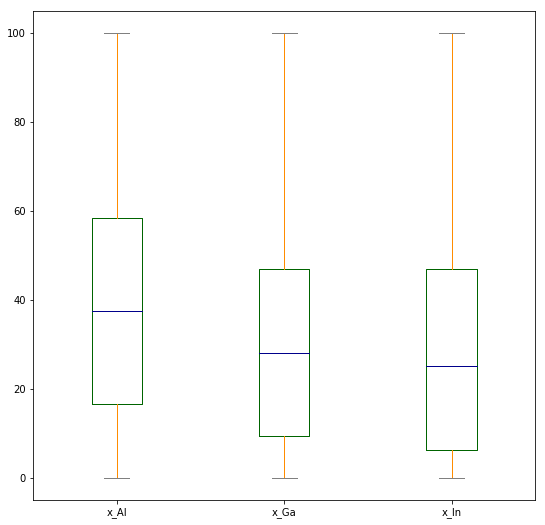

In [199]:
#box-plots of percentage composition of the three elements
color = dict(boxes='DarkGreen', whiskers='DarkOrange',medians='DarkBlue', caps='Gray')
dataset2 = tr[["x_Al","x_Ga","x_In"]]  
dataset2.plot(kind='box',figsize=(9,9),color=color)

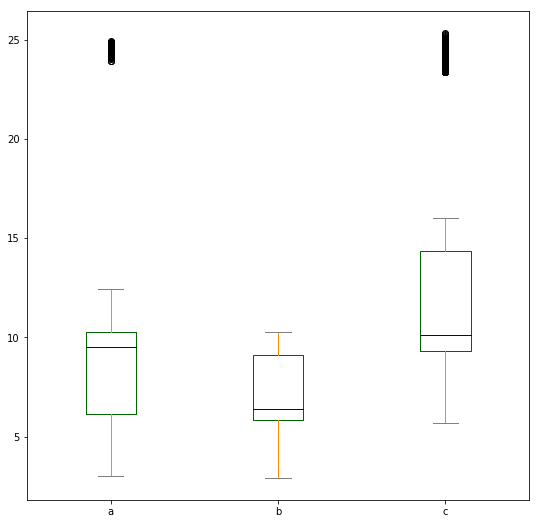

In [200]:
#box-plots of the three lattice vectors
dataset2 = tr[["a","b","c"]]  
dataset2.plot(kind='box',figsize=(9,9),color=color)

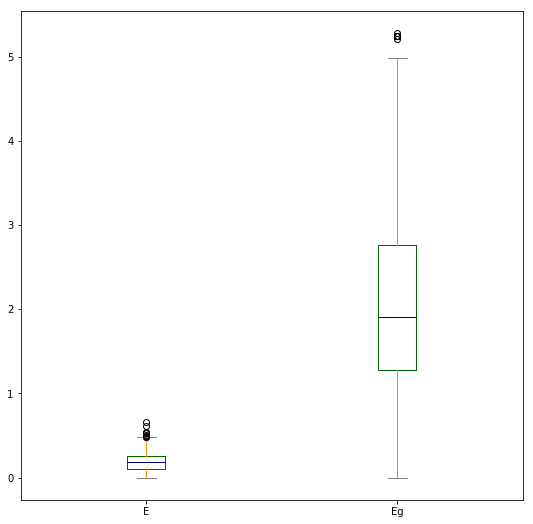

In [201]:
#box-plots of the two target variables
dataset2 = tr[["E","Eg"]]  
dataset2.plot(kind='box',figsize=(9,9),color=color)

In [202]:
tr['Natoms'].value_counts()
# Natoms attribute can be identified as numeric, discrete with six possible values

80.0    1410
40.0     519
30.0     326
20.0      84
60.0      48
10.0      13
Name: Natoms, dtype: int64

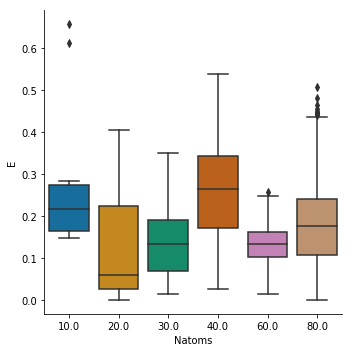

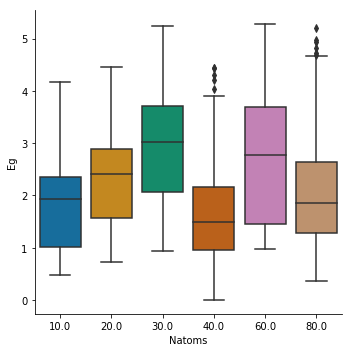

In [203]:
#box-plots of the 2 target variables corresponding to the different values of Natoms
sns.catplot(y='E',x='Natoms',data=tr,palette="colorblind",kind="box")
sns.catplot(y='Eg',x='Natoms',data=tr,palette="colorblind",kind="box")

In [204]:
tr['sg'].value_counts()
#space group is a nominal, discrete valued attribute with 6 diiferent values

206    490
33     432
227    393
167    374
12     358
194    353
Name: sg, dtype: int64

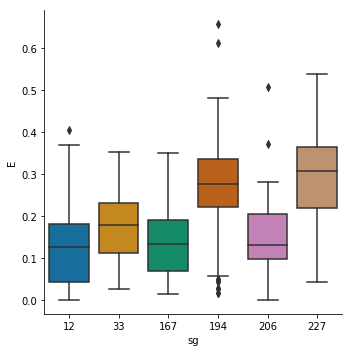

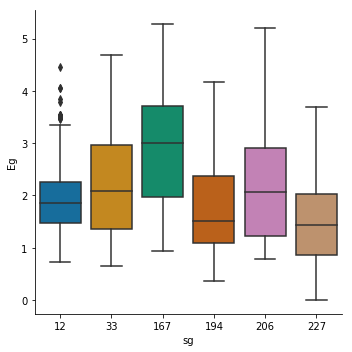

In [205]:
#box-plots of the 2 target variables corresponding to the different values of space group
sns.catplot(y='E',x='sg',data=tr,palette="colorblind",kind="box")
sns.catplot(y='Eg',x='sg',data=tr,palette="colorblind",kind="box")

In [206]:
IQR=Des.loc['75%','Natoms':'Eg']-\
Des.loc['25%','Natoms':'Eg']
IQR

Natoms    40.000000
x_Al      41.660000
x_Ga      37.500000
x_In      40.630000
a          4.151000
b          3.259825
c          5.074050
alpha      0.006500
beta       0.013500
gamma     29.999625
E          0.150675
Eg         1.483450
dtype: float64

## Outlier Analysis :
First, we calculate the IQR for each of the numeric attributes.

In [207]:
IQR['E'].round(6)

0.150675

In [208]:
tr['outliers']=(tr.E>(Des.loc['mean','E']+1.5*IQR['E'])) |\
(tr.E<(Des.loc['mean','E']-1.5*IQR['E']))

In [209]:
IQR['Eg'].round(6)

1.48345

In [210]:
tr['outliers']=(tr.Eg>(Des.loc['mean','Eg']+1.5*IQR['Eg'])) |\
(tr.Eg<(Des.loc['mean','Eg']-1.5*IQR['Eg']))

In [211]:
tr.outliers.value_counts()

False    2349
True       51
Name: outliers, dtype: int64

We then compare the values of the target variables with 1.5IQR to identify the outliers, which come out to be 45 in number

In [212]:
# function to visualize data using scatter plots

def plot_scatter(x, y, xlabel, ylabel):
    """
    Args:
        x (str) - DataFrame column for x-axis
        y (str) - DataFrame column for y-axis
        xlabel (str) - name for x-axis
        ylabel (str) - name for y-axis
    Returns:
        matplotlib scatter plot of y vs x
    """
    s = 75
    lw = 0
    alpha = 0.05
    color = 'blue'
    marker = 'o'
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 16
    label = '__nolegend__'
    ax = plt.scatter(tr[x].values, tr[y].values,
                     marker=marker, color=color, s=s, 
                     lw=lw, alpha=alpha, label=label)
    xrange = abs(tr[x].max() - tr[x].min())
    yrange = abs(tr[y].max() - tr[y].min())
    cushion = 0.1
    xmin = tr[x].min() - cushion*xrange
    xmax = tr[x].max() + cushion*xrange
    ymin = tr[y].min() - cushion*yrange
    ymax = tr[y].max() + cushion*yrange
    ax = plt.xlim([xmin, xmax])
    ax = plt.ylim([ymin, ymax])
    ax = plt.xlabel(xlabel, fontsize=fontsize)
    ax = plt.ylabel(ylabel, fontsize=fontsize)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    return ax

## Scatter Plots :
We visualize the relationship between the target properties and the different features using scatter plots. 

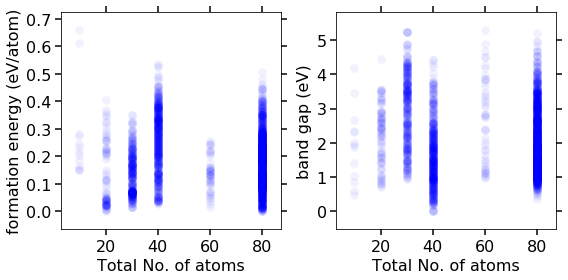

In [213]:
# visualize the relationship between our target properties and the total number of atoms

fig1 = plt.figure(1, figsize=(8, 4))
ax1 = plt.subplot(121)
ax1 = plot_scatter('Natoms', 'E', 
                   'Total No. of atoms', 'formation energy (eV/atom)')
ax2 = plt.subplot(122)
ax2 = plot_scatter('Natoms', 'Eg', 
                   'Total No. of atoms', 'band gap (eV)')
plt.tight_layout()
plt.show()
plt.close()

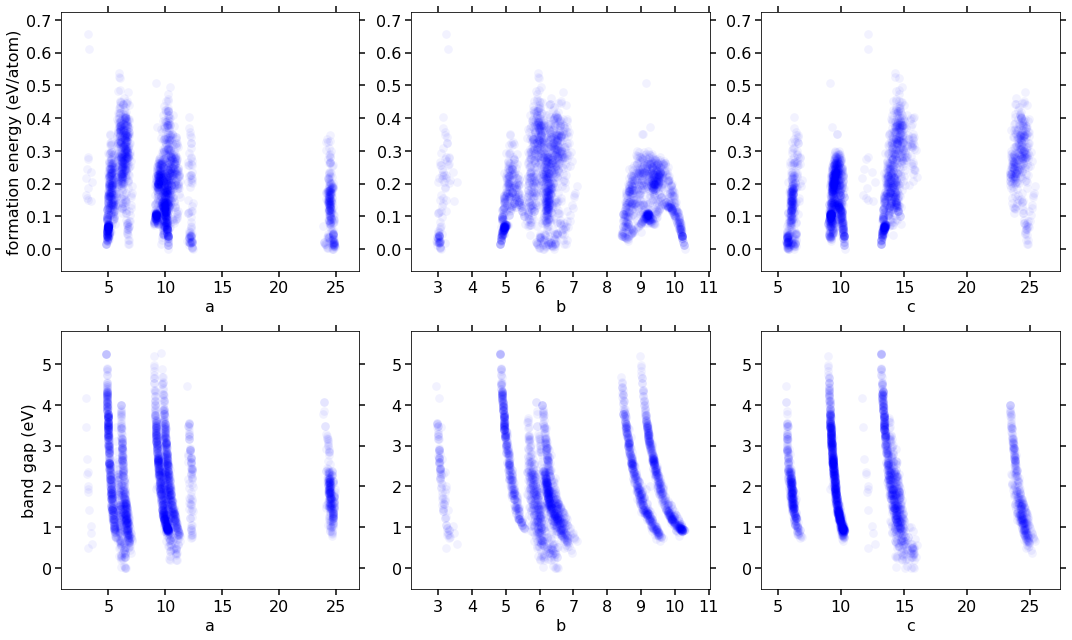

In [214]:
# visualize the relationship between our target properties and the lattice vectors

fig1 = plt.figure(1, figsize=(15, 9))
ax1 = plt.subplot(231)
ax1 = plot_scatter('a', 'E', 
                   'a', 'formation energy (eV/atom)')
ax2 = plt.subplot(232)
ax2 = plot_scatter('b', 'E', 
                   'b', '')
ax3 = plt.subplot(233)
ax3 = plot_scatter('c', 'E', 
                   'c', '')
ax4 = plt.subplot(234)
ax4 = plot_scatter('a', 'Eg', 
                   'a', 'band gap (eV)')
ax5 = plt.subplot(235)
ax5 = plot_scatter('b', 'Eg', 
                   'b', '')
ax6 = plt.subplot(236)
ax6 = plot_scatter('c', 'Eg', 
                   'c', '')


plt.tight_layout()
plt.show()
plt.close()

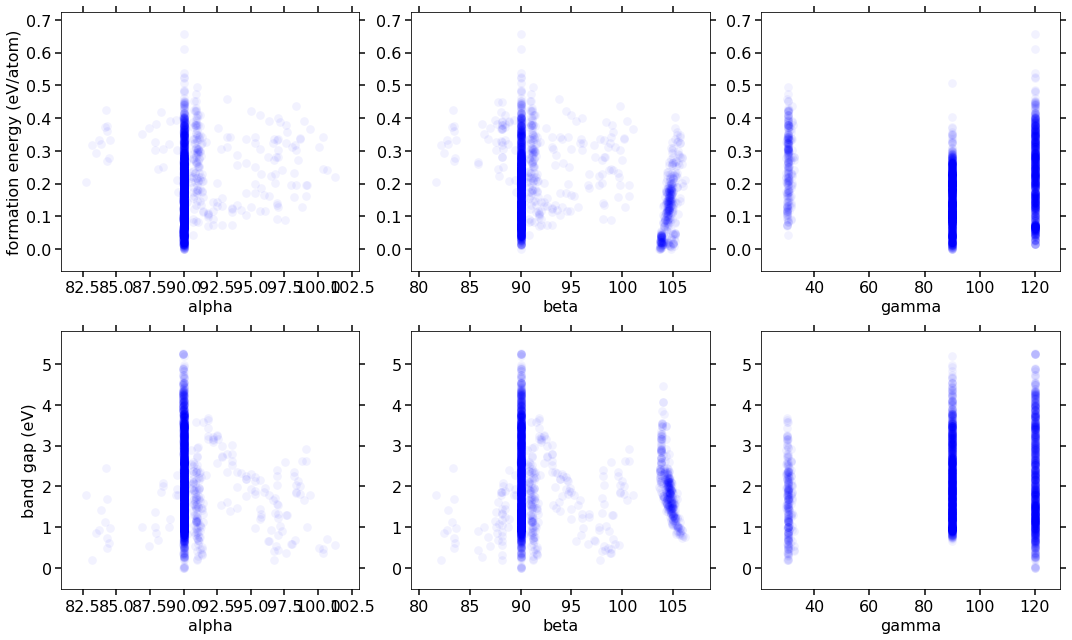

In [215]:
# visualize the relationship between our target properties and the lattice angles

fig1 = plt.figure(1, figsize=(15, 9))
ax1 = plt.subplot(231)
ax1 = plot_scatter('alpha', 'E', 
                   'alpha', 'formation energy (eV/atom)')
ax2 = plt.subplot(232)
ax2 = plot_scatter('beta', 'E', 
                   'beta', '')
ax3 = plt.subplot(233)
ax3 = plot_scatter('gamma', 'E', 
                   'gamma', '')
ax4 = plt.subplot(234)
ax4 = plot_scatter('alpha', 'Eg', 
                   'alpha', 'band gap (eV)')
ax5 = plt.subplot(235)
ax5 = plot_scatter('beta', 'Eg', 
                   'beta', '')
ax6 = plt.subplot(236)
ax6 = plot_scatter('gamma', 'Eg', 
                   'gamma', '')


plt.tight_layout()
plt.show()
plt.close()

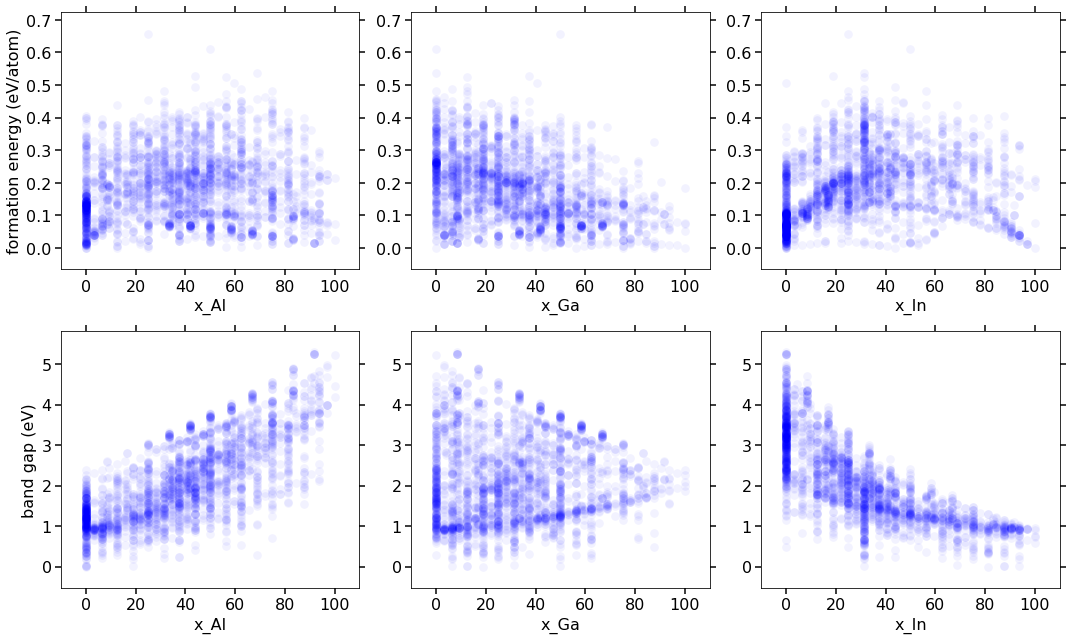

In [216]:
# visualize the relationship between our target properties and the percentage composition of elements

fig1 = plt.figure(1, figsize=(15, 9))
ax1 = plt.subplot(231)
ax1 = plot_scatter('x_Al', 'E', 
                   'x_Al', 'formation energy (eV/atom)')
ax2 = plt.subplot(232)
ax2 = plot_scatter('x_Ga', 'E', 
                   'x_Ga', '')
ax3 = plt.subplot(233)
ax3 = plot_scatter('x_In', 'E', 
                   'x_In', '')
ax4 = plt.subplot(234)
ax4 = plot_scatter('x_Al', 'Eg', 
                   'x_Al', 'band gap (eV)')
ax5 = plt.subplot(235)
ax5 = plot_scatter('x_Ga', 'Eg', 
                   'x_Ga', '')
ax6 = plt.subplot(236)
ax6 = plot_scatter('x_In', 'Eg', 
                   'x_In', '')


plt.tight_layout()
plt.show()
plt.close()

## Correlation analysis :
Now, we check how our features interact with each other. There are two aims here, namely, identifying whether any of the features strongly correlate with each other so that any one of them can be neglected fromn further analysis, and dicovering any strong correlation with the target variables

In [217]:
corr = tr.loc[:,'id':'Eg'].corr()
corr

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma,E,Eg
id,1.000000,0.042268,-0.037464,0.021495,-0.010629,-0.012250,-0.041701,-0.036477,0.041349,0.005916,-0.031354,0.008565,-0.008242,0.034987
sg,0.042268,1.000000,-0.137534,0.052268,-0.053061,-0.005620,-0.570607,-0.012211,0.569755,0.183916,-0.584661,-0.007700,0.324927,-0.072725
Natoms,-0.037464,-0.137534,1.000000,-0.106022,-0.012030,0.117657,0.397917,0.651364,-0.002656,-0.172047,0.039425,0.055687,-0.048631,-0.106125
x_Al,0.021495,0.052268,-0.106022,1.000000,-0.450122,-0.609300,-0.154387,-0.179604,0.032261,0.019183,-0.099428,-0.019175,0.108481,0.738622
x_Ga,-0.010629,-0.053061,-0.012030,-0.450122,1.000000,-0.433809,0.100244,-0.125285,-0.024424,0.000648,0.128669,0.010230,-0.374817,0.012831
x_In,-0.012250,-0.005620,0.117657,-0.609300,-0.433809,1.000000,0.066761,0.292472,-0.010866,-0.019929,-0.013933,0.010259,0.223383,-0.756668
a,-0.041701,-0.570607,0.397917,-0.154387,0.100244,0.066761,1.000000,-0.017117,-0.560387,0.002739,0.850079,-0.303708,-0.225600,-0.138901
b,-0.036477,-0.012211,0.651364,-0.179604,-0.125285,0.292472,-0.017117,1.000000,-0.256180,-0.114209,-0.365709,-0.146586,-0.104137,-0.127461
c,0.041349,0.569755,-0.002656,0.032261,-0.024424,-0.010866,-0.560387,-0.256180,1.000000,0.071834,-0.471228,0.328274,0.454679,-0.156865
alpha,0.005916,0.183916,-0.172047,0.019183,0.000648,-0.019929,0.002739,-0.114209,0.071834,1.000000,0.189144,-0.446694,0.099277,-0.072313


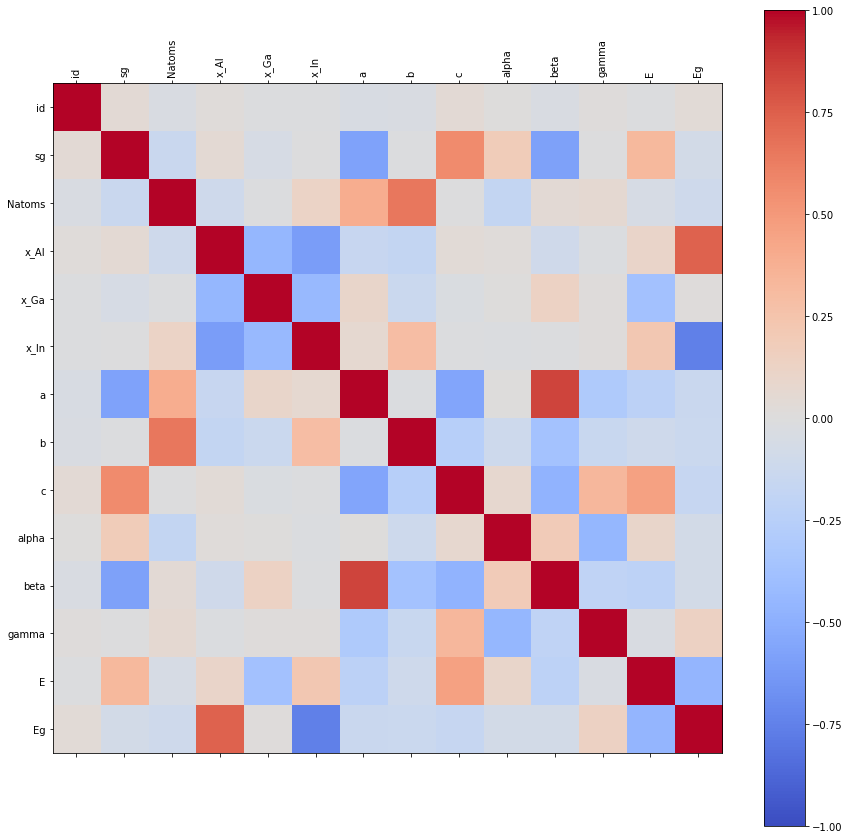

In [218]:
#heatmap to show the strength of correlation
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(tr.loc[:,'id':'Eg'].columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(tr.loc[:,'id':'Eg'].columns)
ax.set_yticklabels(tr.loc[:,'id':'Eg'].columns)
plt.show()

In [219]:
#finding pairs of features with correlation greater than 0.9
count=0
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            count=count+1
            if columns[j]:
                columns[j] = False
if count==0:
    print("None of the features have correlation >= 0.9")    

None of the features have correlation >= 0.9


### Selecting features based on correlation
We generated a correlation matrix and saw the strength of correlation using a heat map. Then we checked for pairs of features with correlation greater than 0.9 so that we could remove one of each pair.

We concluded that since there is no pair with corr. > 0.9, the corr. between any 2 features is not strong enough to remove any of them.

# Feature engineering :
Analysing above scatter plots, we draw some inferences as to how the target variables are correlated with the existing features. Now, we aim to engineer new features using the existing ones and hope to achieve better correlation with the target variables.

## 1. Volume of the lattice unit cell :
We calculate the value of the parallelepiped unit cell using the lengths of the lattice vectors and the lattice angles and see its relationship with the target variables.

In [220]:
# calculate the volume of the structure

def get_vol(a, b, c, alpha, beta, gamma):
    """
    Args:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['alpha', 'beta', 'gamma']
for lang in lattice_angles:
    tr['_'.join([lang, 'r'])] = np.pi * tr[lang] / 180
    # compute the cell volumes 
tr['vol'] = get_vol(tr['a'], tr['b'], tr['c'],
                          tr['alpha_r'], tr['beta_r'], tr['gamma_r'])
tr[['a','b','c','alpha_r','beta_r','gamma_r','vol']].head()

,a,b,c,alpha_r,beta_r,gamma_r,vol
0,9.9523,8.5513,9.1775,1.570842,1.570836,1.570826,781.052081
1,6.1840,6.1838,23.6287,1.571121,1.570761,2.094439,782.500110
2,9.7510,5.6595,13.9630,1.587705,1.590393,0.532648,391.227531
3,5.0036,5.0034,13.5318,1.570601,1.571004,2.094425,293.377334
4,6.6614,6.6612,24.5813,1.570727,1.570807,2.094208,944.713843


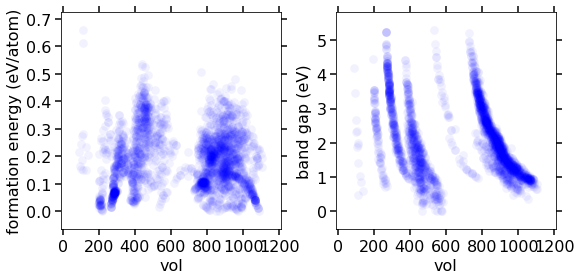

In [221]:
# visualize the relationship between our target properties and the volume

fig1 = plt.figure(1, figsize=(8, 4))
ax1 = plt.subplot(121)
ax1 = plot_scatter('vol', 'E', 
                   'vol', 'formation energy (eV/atom)')
ax2 = plt.subplot(122)
ax2 = plot_scatter('vol', 'Eg', 
                   'vol', 'band gap (eV)')
plt.tight_layout()
plt.show()
plt.close()

## 2. Atomic density :
Next we incorporate the number of atoms in the lattice and calculate the atomic number density.

In [222]:
# calculate the atomic density

# this is known to correlate with stability or bonding strength
tr['atomic_density'] = tr['Natoms'] / tr['vol']   

tr[['a','b','c','alpha','beta','gamma','vol', 'Natoms', 'atomic_density']].head()

,a,b,c,alpha,beta,gamma,vol,Natoms,atomic_density
0,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,781.052081,80.0,0.102426
1,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,782.500110,80.0,0.102236
2,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,391.227531,40.0,0.102242
3,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,293.377334,30.0,0.102257
4,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,944.713843,80.0,0.084682


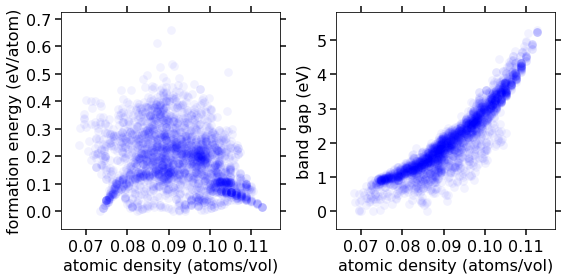

In [223]:
# visualize the relationship between our target properties and the atomic density

fig1 = plt.figure(1, figsize=(8, 4))
ax1 = plt.subplot(121)
ax1 = plot_scatter('atomic_density', 'E', 
                   'atomic density (atoms/vol)', 'formation energy (eV/atom)')
ax2 = plt.subplot(122)
ax2 = plot_scatter('atomic_density', 'Eg', 
                   'atomic density (atoms/vol)', 'band gap (eV)')
plt.tight_layout()
plt.show()
plt.close()

# Geometry.xyz files :
Apart from the 14 attributes to each from, there is also a geometry.xyz files corresponding to each row which contains spatial information of each material.

## Information contained in the .xyz file
We run the following function get_xyz_data which opens the .xyz file and returns the data stored in it as a table with five columns.

In [224]:
row_id=0

In [225]:
def get_xyz_data(filename, ids):
    
    A = pd.DataFrame(columns=list('ABCDE'))
    B = pd.DataFrame(columns=list('ABCE'))
    
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            if x[0] == 'atom':

                newrowA = pd.DataFrame([[x[1],x[2],x[3],x[4],ids]], columns=list('ABCDE'))
                A = A.append(newrowA)
                
            elif x[0] == 'lattice_vector':
                
                newrowB = pd.DataFrame([[x[1],x[2],x[3],ids]], columns=list('ABCE'))
                B = B.append(newrowB)

    return A, B

In [226]:
#sample data from geometry.xyz file of a random index
get_xyz_data("train/{}/geometry.xyz".format(298), 298)

(                     A                   B                    C   D    E
 0  12.0173105877394661  1.9900717893136055   3.1339166541539480  Al  298
 0   8.8834544122427062  1.9707461672216009  11.4953421725586438  Al  298
 0   5.1659332439510761  1.9872103973726301   1.8599268776620173  In  298
 0   5.5161321839510764  1.9657364498726300  12.6580315376620174  In  298
 0   8.5916219622427068  1.9886411234716010   2.4969216225586441  Al  298
 0  12.3091430377394655  1.9721768330636054  12.1323372041539486  Al  298
 0   9.5223394077394659  0.4943845930636052   4.9023312391539475  Ga  298
 0   1.1624005172427048  0.4782814584716009   9.6087383325586444  In  298
 0   6.9663273427394659  1.9825573030636052   4.8779505591539483  Al  298
 0   3.7157381872427049  1.9703896634716012   9.6400078575586434  Al  298
 0   8.7667214369120252  1.9779041494352816   7.8959740965333740  In  298
 0  12.1340435630701471  1.9829138070999248   6.7332847301792196  Al  298
 0   5.3410327139510763  1.97647342362

Columns A, B and C give the x, y and z co-ordinates respectively of the atoms present in a unit cell of the lattice.
D contains the symbol of the element present at that position in space.
E contains the index of the material.

## Principal Component Analysis (PCA) :
Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called principal components.

### Applying PCA to geometry.xyz files
As shown above, each geomtery file contains a host of information which might be difficult to utilize in further analysis. So we apply PCA to these 3-D files to convert them into linearly uncorrelated PCs which we can perhaps further use in our project.

The PCA algorithm is leveraged to project the 3D points that are contained in the xyz-files onto the 2D plane. While in the 3D space some patterns might remain unrevealed, the projection along their greatest variance might provide a more accessible view to the point configurations.

In [227]:
def pca(index):
    fn = "train/{}/geometry.xyz".format(index)
    train_xyz, train_lat = get_xyz_data(fn, index)
    matrix = train_xyz
    colour = matrix["D"]
    matrix = matrix[["A","B","C"]].as_matrix()
    matrix = matrix.astype(float)
    pca = PCA(n_components=3)
    X_r = pca.fit(matrix).transform(matrix)
    df_ = pd.DataFrame(np.round(X_r,2))
        
    x = np.array(matrix[:,0])
    y = np.array(matrix[:,1])
    z = np.array(matrix[:,2])
    hull = ConvexHull(X_r[:,[0,1]])
    volume_1 = hull.volume
    hull = ConvexHull(X_r[:,[0,2]])
    volume_2 = hull.volume
    hull = ConvexHull(X_r[:,[1,2]])
    volume_3 = hull.volume
    return volume_1,volume_2,volume_3
    

## Plotting the principal components
The following function plots the 3 PCs versus each other and also visualize the convex hull of the 2-D projection.

In [228]:
# plot_pca performs pca on the atom configuration and plots it
# Moreover, the convex hull of the projection is computed and also visualized in the plot

def plot_pca(index):
    
    fn = "train/{}/geometry.xyz".format(index)
    train_xyz, train_lat = get_xyz_data(fn, index)
    color_dict = { 'Ga':'black', 'Al':'blue', 'O':'red', 'In':'green' }
    
    matrix = train_xyz
    colour = matrix["D"]
    matrix = matrix[["A","B","C"]].as_matrix()
    matrix = matrix.astype(float)
    
    pca = PCA(n_components=3)
    X_r = pca.fit(matrix).transform(matrix)
    df_ = pd.DataFrame(np.round(X_r,2))
        
    x = np.array(matrix[:,0])
    y = np.array(matrix[:,1])
    z = np.array(matrix[:,2])

    fig = plt.figure(figsize=(20,20))

    ax = fig.add_subplot(221, projection='3d')
    ax.scatter(x,y,z, c=[ color_dict[i] for i in colour ], marker='o', s=70)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(label.loc[index])
    
    ax = fig.add_subplot(222)
    plt.scatter(X_r[:, 0], X_r[:, 1], color=[color_dict[i] for i in colour], alpha=.8, lw=1, s=70)
    hull = ConvexHull(X_r[:,[0,1]])
    volume_1 = hull.volume
    plt.plot(X_r[hull.vertices,0], X_r[hull.vertices,1], 'r--', lw=1)
    plt.title(label.loc[index])
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title(label.loc[index])
    
    ax = fig.add_subplot(223)
    plt.scatter(X_r[:, 0], X_r[:, 2], color=[color_dict[i] for i in colour], alpha=.8, lw=1, s=70)
    hull = ConvexHull(X_r[:,[0,2]])
    volume_2 = hull.volume
    plt.plot(X_r[hull.vertices,0], X_r[hull.vertices,2], 'r--', lw=1)
    plt.title(label.loc[index])
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Third Principal Component')
    ax.set_title(label.loc[index])
    
    ax = fig.add_subplot(224)
    plt.scatter(X_r[:, 1], X_r[:, 2], color=[color_dict[i]
    for i in colour], alpha=.8, lw=1, s=70)
    hull = ConvexHull(X_r[:,[1,2]])
    volume_3 = hull.volume
    plt.plot(X_r[hull.vertices,1], X_r[hull.vertices,2], 'r--', lw=1)
    plt.title(label.loc[index])
    ax.set_xlabel('Second Principal Component')
    ax.set_ylabel('Third Principal Component')
    ax.set_title(label.loc[index])
    
    plt.show()
    
    print("On the first principle component are approx. " + str(len(df_[0].unique())) + " distinct coordinates with atoms")
    print("On the second principle component are approx. " + str(len(df_[1].unique())) + " distinct coordinates with atoms")
    print("On the third principle component are approx. " + str(len(df_[2].unique())) + " distinct coordinates with atoms")
    print("")
    print("Area covered by the first and second principal component: " + str(volume_1))
    print("Area covered by the first and third principal component: " + str(volume_2))
    print("Area covered by the second and third principal component: " + str(volume_3))
                                             

/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


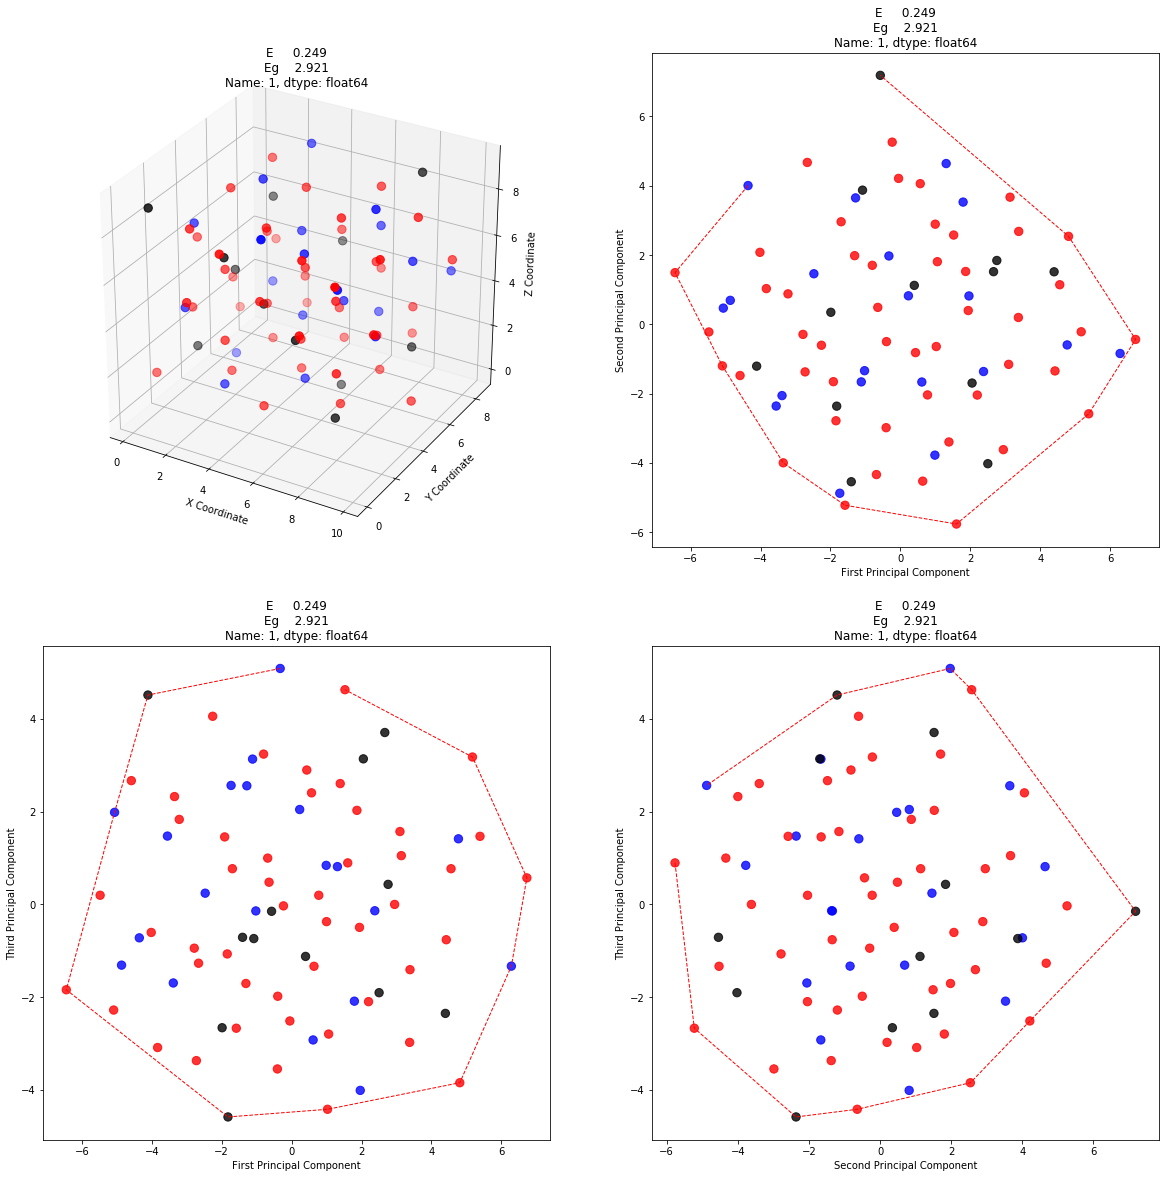

On the first principle component are approx. 80 distinct coordinates with atoms
On the second principle component are approx. 74 distinct coordinates with atoms
On the third principle component are approx. 74 distinct coordinates with atoms

Area covered by the first and second principal component: 102.92310075350419
Area covered by the first and third principal component: 94.85620497103969
Area covered by the second and third principal component: 84.12362767374218


In [229]:
plot_pca(1)

## Calculating and storing areas covered by the pairs of PCs
We calculate the areas covered by pairs of PCs and append corresponding 3 new cloumns, namely, A_12, A_13 and A_23.

In [73]:
ans2=[]

for i in range(2400):
    ans2.append(pca(index=i+1))


/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [230]:
# Area covered by differenc principal components
m1=np.asarray([row[0] for row in ans2])
m2=np.asarray([row[1] for row in ans2])
m3=np.asarray([row[2] for row in ans2])


In [231]:
tr['A_12']=m1
tr['A_13']=m2
tr['A_23']=m3

In [232]:
tr.head()

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,...,Eg,outliers,alpha_r,beta_r,gamma_r,vol,atomic_density,A_12,A_13,A_23
0,1,33,80.0,62.50,37.50,0.0,9.9523,8.5513,9.1775,90.0026,...,3.4387,False,1.570842,1.570836,1.570826,781.052081,0.102426,102.923101,94.856205,84.123628
1,2,194,80.0,62.50,37.50,0.0,6.1840,6.1838,23.6287,90.0186,...,2.9210,False,1.571121,1.570761,2.094439,782.500110,0.102236,151.322628,104.324312,22.704945
2,3,227,40.0,81.25,18.75,0.0,9.7510,5.6595,13.9630,90.9688,...,2.7438,False,1.587705,1.590393,0.532648,391.227531,0.102242,126.054703,24.688331,15.051472
3,4,167,30.0,75.00,0.00,25.0,5.0036,5.0034,13.5318,89.9888,...,3.3492,False,1.570601,1.571004,2.094425,293.377334,0.102257,64.827257,43.876742,17.463460
4,5,194,80.0,0.00,62.50,37.5,6.6614,6.6612,24.5813,89.9960,...,1.3793,False,1.570727,1.570807,2.094208,944.713843,0.084682,169.577126,116.940283,26.362348


## Calculating and storing variances of first two PCs
PCA transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

The followinf function calculates variance of the first 2 PCs for each row and appends them in 2 corresponding new columns, namely, Var_PCA_1 and Var_PCA_2.

In [233]:
X_train=[]
def geo(index):
    fn = "train/{}/geometry.xyz".format(index)
    train_xyz, train_lat = get_xyz_data(fn, index)
    
    return train_xyz.iloc[:,[0,1,2]]

In [234]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

In [79]:
# Calculating variance of the first two PCs
explained_variance=[]
from sklearn.decomposition import PCA
for i in range(2400):
    pca=PCA(n_components=2)
    pca.fit_transform(geo(i+1))
    explained_variance.append(pca.explained_variance_ratio_)
    


In [235]:
# Calculating both components of explained varinace ratio
n1=np.asarray([row[0] for row in explained_variance])
n2=np.asarray([row[1] for row in explained_variance])


In [236]:
tr['Var_PCA_1']=n1
tr['Var_PCA_2']=n2

In [237]:
tr.head()

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,...,alpha_r,beta_r,gamma_r,vol,atomic_density,A_12,A_13,A_23,Var_PCA_1,Var_PCA_2
0,1,33,80.0,62.50,37.50,0.0,9.9523,8.5513,9.1775,90.0026,...,1.570842,1.570836,1.570826,781.052081,0.102426,102.923101,94.856205,84.123628,0.411435,0.345052
1,2,194,80.0,62.50,37.50,0.0,6.1840,6.1838,23.6287,90.0186,...,1.571121,1.570761,2.094439,782.500110,0.102236,151.322628,104.324312,22.704945,0.889178,0.071873
2,3,227,40.0,81.25,18.75,0.0,9.7510,5.6595,13.9630,90.9688,...,1.587705,1.590393,0.532648,391.227531,0.102242,126.054703,24.688331,15.051472,0.627590,0.355256
3,4,167,30.0,75.00,0.00,25.0,5.0036,5.0034,13.5318,89.9888,...,1.570601,1.571004,2.094425,293.377334,0.102257,64.827257,43.876742,17.463460,0.797074,0.132037
4,5,194,80.0,0.00,62.50,37.5,6.6614,6.6612,24.5813,89.9960,...,1.570727,1.570807,2.094208,944.713843,0.084682,169.577126,116.940283,26.362348,0.882122,0.076434


### Removing the duplicate rows
After computing all the new features for each row, we now look for duplicate rows, and remove them. 

In [238]:
tr[tr.duplicated(['sg','Natoms','x_Al','x_Ga','x_In','a','b','c','alpha','beta','gamma','A_12','A_13','A_23','Var_PCA_1','Var_PCA_2','E','Eg'])]

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,...,alpha_r,beta_r,gamma_r,vol,atomic_density,A_12,A_13,A_23,Var_PCA_1,Var_PCA_2
693,694,167,30.0,91.67,8.33,0.00,4.8328,4.8326,13.1683,89.9848,...,1.570531,1.571076,2.094427,266.337376,0.112639,61.165312,41.467689,16.402559,0.799170,0.130569
986,987,12,80.0,81.25,18.75,0.00,24.0773,5.9380,5.7108,89.9992,...,1.570782,1.814244,1.570800,792.403142,0.100959,108.644031,93.924560,21.400608,0.910978,0.051243
1008,1009,12,20.0,62.50,37.50,0.00,12.1361,2.9957,5.7492,89.9994,...,1.570786,1.813058,1.570800,202.914766,0.098564,42.511381,17.980385,6.652525,0.839840,0.124120
1072,1073,206,80.0,0.00,3.12,96.88,10.2626,10.2626,10.2629,90.0005,...,1.570805,1.570805,1.570782,1080.898467,0.074013,119.147986,103.141324,107.300852,0.335888,0.335866
1158,1159,206,80.0,18.75,0.00,81.25,10.0455,10.0454,10.0457,90.0006,...,1.570807,1.570810,1.570784,1013.722292,0.078917,114.158234,102.015998,101.043863,0.335890,0.335867
1435,1436,12,20.0,75.00,25.00,0.00,12.0711,2.9779,5.7236,89.9992,...,1.570782,1.813847,1.570800,199.696380,0.100152,42.087609,17.783584,6.581600,0.839791,0.124223
1678,1679,206,80.0,0.00,18.75,81.25,10.1241,10.1241,10.1242,90.0013,...,1.570819,1.570817,1.570763,1037.704184,0.077093,115.951734,100.140216,104.495570,0.335893,0.335863
1768,1769,12,20.0,37.50,62.50,0.00,12.2659,3.0312,5.8004,89.9997,...,1.570791,1.811496,1.570800,209.443943,0.095491,43.365647,18.377240,6.795538,0.839936,0.123918
1856,1857,167,30.0,83.33,8.33,8.33,4.8966,4.8964,13.3033,89.9868,...,1.570566,1.571042,2.094425,276.219337,0.108609,62.608042,42.445401,16.838797,0.798239,0.131173
1888,1889,167,60.0,0.00,25.00,75.00,10.8972,5.4481,14.4666,89.9988,...,1.570775,1.570784,2.094411,743.794835,0.080667,145.031800,62.422754,47.067979,0.593007,0.341905


We find 14 duplicate rows, which don't need to be included in further project.

## Correlation analysis of the engineered features
Now we plot the heatmap of correlation among the target variables and the newly engineered features.

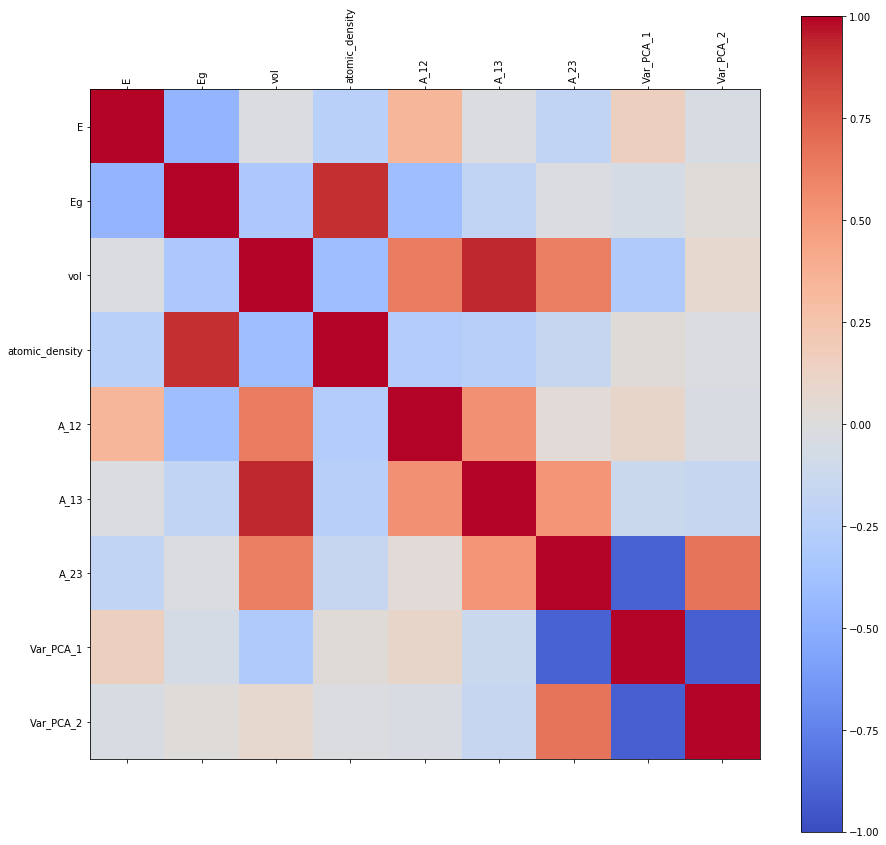

In [239]:
corr = tr.loc[:,['E', 'Eg', 'vol', 'atomic_density', 'A_12', 'A_13', 'A_23', 'Var_PCA_1', 'Var_PCA_2']].corr()
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(tr.loc[:,['E', 'Eg', 'vol', 'atomic_density', 'A_12', 'A_13', 'A_23', 'Var_PCA_1', 'Var_PCA_2']].columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(tr.loc[:,['E', 'Eg', 'vol', 'atomic_density', 'A_12', 'A_13', 'A_23', 'Var_PCA_1', 'Var_PCA_2']].columns)
ax.set_yticklabels(tr.loc[:,['E', 'Eg', 'vol', 'atomic_density', 'A_12', 'A_13', 'A_23', 'Var_PCA_1', 'Var_PCA_2']].columns)
plt.show()

### Useful conclusion :
Atomic density has a strong positive correlation with one of the target variables, band energy gap.

## Feature importance using the Random Forest Algorithm
Random forests can be used to rank the importance of variables in a regression or classification problem in a natural way.

To measure the importance of the j-th feature, the values of the j-th feature are permuted among the training data and the out-of-bag error is again computed on this perturbed data set. The importance score for the j-th feature is computed by averaging the difference in out-of-bag error before and after the permutation over all trees. The score is normalized by the standard deviation of these differences.

Features which produce large values for this score are ranked as more important than features which produce small values.

In [240]:
# use random forests to quantify the importances of each feature

# list of columns not to be used for training
non_features = ['id', 'E', 'Eg',
               'alpha_r', 'beta_r', 'gamma_r']

# list of columns to be used for training each model
features = [col for col in list(tr) if col not in non_features]
print('%i features: %s' % (len(features), features))

# make feature matrix
X = tr[features].values

# make target columns for each target property
y_E = tr['E'].values
y_Eg = tr['Eg'].values

# split into training and test for the purposes of this demonstration
test_size = 0.2
rstate = 42
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X, y_E, 
                                                            test_size=test_size,
                                                            random_state=rstate)
X_train_Eg, X_test_Eg, y_train_Eg, y_test_Eg = train_test_split(X, y_Eg, 
                                                                test_size=test_size, 
                                                                random_state=rstate)

# number of base decision tree estimators
n_est = 100
# maximum depth of any given decision tree estimator
max_depth = 5
# random state variable
rstate = 42
# initialize a random forest algorithm
rf_E = RandomForestRegressor(n_estimators=n_est, 
                             max_depth=max_depth,
                             random_state=rstate)
rf_Eg = RandomForestRegressor(n_estimators=n_est, 
                             max_depth=max_depth,
                             random_state=rstate)
# fit to training data
rf_E.fit(X_train_E, y_train_E)
rf_Eg.fit(X_train_Eg, y_train_Eg)

19 features: ['sg', 'Natoms', 'x_Al', 'x_Ga', 'x_In', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'outliers', 'vol', 'atomic_density', 'A_12', 'A_13', 'A_23', 'Var_PCA_1', 'Var_PCA_2']


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [241]:
#report the most important featuers for predicting each target

# collect ranking of most "important" features for E
importances_E =  rf_E.feature_importances_
descending_indices_E = np.argsort(importances_E)[::-1]
sorted_importances_E = [importances_E[idx] for idx in descending_indices_E]
sorted_features_E = [features[idx] for idx in descending_indices_E]
print('most important feature for formation energy is %s' % sorted_features_E[0])

# collect ranking of most "important" features for Eg
importances_Eg =  rf_Eg.feature_importances_
descending_indices_Eg = np.argsort(importances_Eg)[::-1]
sorted_importances_Eg = [importances_Eg[idx] for idx in descending_indices_Eg]
sorted_features_Eg = [features[idx] for idx in descending_indices_Eg]
print('most important feature for band gap is %s' % sorted_features_Eg[0])

most important feature for formation energy is c
most important feature for band gap is atomic_density


## Conclusion from RFA
After ranking the features according to their importances computed by RFA, we conclude that :
1. most important feature for formation energy is c
2. most important feature for band gap is atomic_density

## Data Preparation



In [265]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [266]:
all = pd.concat([tr[feature_columns], test])

scaler = MinMaxScaler()
#scaler = StandardScaler()
scaler.fit(all[transform_columns])

tr[transform_columns] = scaler.transform(tr[transform_columns])
test[transform_columns] = scaler.transform(test[transform_columns])

/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [246]:
tr.head()

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,...,alpha_r,beta_r,gamma_r,vol,atomic_density,A_12,A_13,A_23,Var_PCA_1,Var_PCA_2
0,1,33,1.000000,0.6250,0.3750,0.000,0.316108,0.763337,0.178158,0.392655,...,1.570842,1.570836,1.570826,781.052081,0.102426,102.923101,94.856205,84.123628,0.411435,0.345052
1,2,194,1.000000,0.6250,0.3750,0.000,0.143854,0.441140,0.912710,0.393520,...,1.571121,1.570761,2.094439,782.500110,0.102236,151.322628,104.324312,22.704945,0.889178,0.071873
2,3,227,0.428571,0.8125,0.1875,0.000,0.306906,0.369788,0.421404,0.444922,...,1.587705,1.590393,0.532648,391.227531,0.102242,126.054703,24.688331,15.051472,0.627590,0.355256
3,4,167,0.285714,0.7500,0.0000,0.250,0.089896,0.280498,0.399487,0.391908,...,1.570601,1.571004,2.094425,293.377334,0.102257,64.827257,43.876742,17.463460,0.797074,0.132037
4,5,194,1.000000,0.0000,0.6250,0.375,0.165676,0.506111,0.961130,0.392298,...,1.570727,1.570807,2.094208,944.713843,0.084682,169.577126,116.940283,26.362348,0.882122,0.076434


In [247]:
t1 = 'E'
t2 = 'Eg'


In [248]:
random_seed = 314

X_train, X_validation = train_test_split(tr, test_size=0.2, random_state=random_seed)

y_train = np.log1p(X_train[[t1, t2]])
X_train = X_train.drop(['id', t1, t2], axis=1)

y_validation = np.log1p(X_validation[[t1, t2]])
X_validation = X_validation.drop(['id', t1, t2], axis=1)

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(1920, 22) (1920, 2)
(480, 22) (480, 2)


In [249]:
X_train.head()


,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,...,alpha_r,beta_r,gamma_r,vol,atomic_density,A_12,A_13,A_23,Var_PCA_1,Var_PCA_2
1064,167,0.285714,0.7500,0.0833,0.1667,0.087921,0.274619,0.394734,0.391898,0.341299,...,1.570597,1.571011,2.094423,286.341197,0.104770,64.067429,43.434391,17.280814,0.797325,0.131765
346,12,1.000000,0.3750,0.3125,0.3125,0.978790,0.448421,0.022777,0.392503,0.938402,...,1.570793,1.826616,1.570798,903.004947,0.088593,116.284806,101.895202,24.105494,0.904285,0.054339
1408,206,1.000000,0.3750,0.3750,0.2500,0.293979,0.888078,0.192919,0.392682,0.340932,...,1.570850,1.570854,1.570739,848.740147,0.094257,101.410439,90.280467,90.213086,0.335905,0.335860
590,194,1.000000,0.1562,0.1250,0.7188,0.174910,0.533560,0.977640,0.393299,0.340618,...,1.571049,1.570720,2.094175,1016.104682,0.078732,177.019512,122.085426,27.993682,0.878605,0.078712
1583,206,1.000000,0.0000,0.4375,0.5625,0.313827,0.947210,0.215000,0.392660,0.340891,...,1.570843,1.570836,1.570733,970.995034,0.082390,110.928107,95.776052,100.034820,0.335901,0.335857


In [250]:
y_train.head()


,E,Eg
1064,0.150573,1.516752
346,0.178146,0.919087
1408,0.176890,1.198186
590,0.279826,0.548526
1583,0.119204,0.768487


In [251]:
X_validation.head()


,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,...,alpha_r,beta_r,gamma_r,vol,atomic_density,A_12,A_13,A_23,Var_PCA_1,Var_PCA_2
1791,12,1.000000,0.4375,0.2812,0.2812,0.976198,0.443617,0.020500,0.392498,0.935919,...,1.570791,1.825553,1.570798,889.501884,0.089938,115.322094,100.942851,23.792117,0.904948,0.054024
1118,227,0.428571,0.3125,0.5625,0.1250,0.326585,0.401769,0.437182,0.371071,0.322299,...,1.563878,1.562878,0.528365,431.825599,0.092630,134.543308,25.904687,16.197726,0.612421,0.370251
1831,227,0.428571,0.2500,0.4375,0.3125,0.338004,0.414303,0.468214,0.771315,0.582242,...,1.693011,1.674153,0.527236,464.167078,0.086176,152.032674,30.211941,18.730353,0.649711,0.337401
1942,194,1.000000,0.2188,0.4062,0.3750,0.162380,0.496285,0.952749,0.392958,0.340920,...,1.570939,1.570849,2.094250,918.136724,0.087133,166.611045,114.892353,25.792017,0.882987,0.075876
226,167,0.285714,0.7500,0.1667,0.0833,0.085946,0.268740,0.389987,0.391881,0.341315,...,1.570592,1.571018,2.094421,279.419981,0.107365,63.068087,42.757176,16.981046,0.797892,0.131398


In [252]:
y_validation.head()


,E,Eg
1791,0.113418,1.069252
1118,0.162119,1.023458
1831,0.291101,0.587731
1942,0.309908,0.719740
226,0.115558,1.625429


In [253]:
import tensorflow as tf


## Neural Network



In [254]:
tf.set_random_seed(1)
np.random.seed(1)

layers = [16] * 8

activation = tf.tanh

kernel_regularizer_l2 = None

In [255]:
tf.reset_default_graph() 

tf_is_training = tf.placeholder(tf.bool, None)

tf_x = tf.placeholder(tf.float32, (None, X_train.shape[1]), name='tf_x')
tf_y = tf.placeholder(tf.float32, (None, 2), name='tf_y')

In [256]:
l = tf_x
for i, n in enumerate(layers):
    l = tf.layers.dense(l, n, activation=activation, kernel_regularizer=kernel_regularizer_l2, name='layer%s' % (i + 1))

#     if i == 0:
#         l = tf.layers.dropout(l, training=tf_is_training, name='dropout%s' % (i + 1))

output = tf.layers.dense(l, 2, name='output')

In [257]:
# loss
loss_y = tf.sqrt(tf.reduce_mean(tf.squared_difference(tf_y, output), 0), name='tf_y_loss')
loss_total = tf.reduce_mean(loss_y, name='tf_total_loss')

rl = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
if len(rl) > 0:
    loss_total += tf.add_n(rl)

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
#optimizer = tf.train.MomentumOptimizer(learning_rate=0.05, momentum=1.0)
optimizer = tf.train.AdamOptimizer(learning_rate=0.002)
train_op = optimizer.minimize(loss_total)

## Training

In [258]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [259]:
loss_data = []

for step in range(500):
    # training loss
    _, lt, lt_y = sess.run([train_op, loss_total, loss_y], {tf_x: X_train, tf_y: y_train, tf_is_training: True})
    
    # validation loss
    lv, lv_y = sess.run([loss_total, loss_y], {tf_x: X_validation, tf_y: y_validation, tf_is_training: False})
    
    loss_data.append([step, lt, lt_y[0], lt_y[1], lv, lv_y[0], lv_y[1]])

loss_data = np.array(loss_data)

print(loss_data[-1][1:])

[0.18192101 0.07629804 0.28754398 0.17843962 0.07792112 0.27895811]


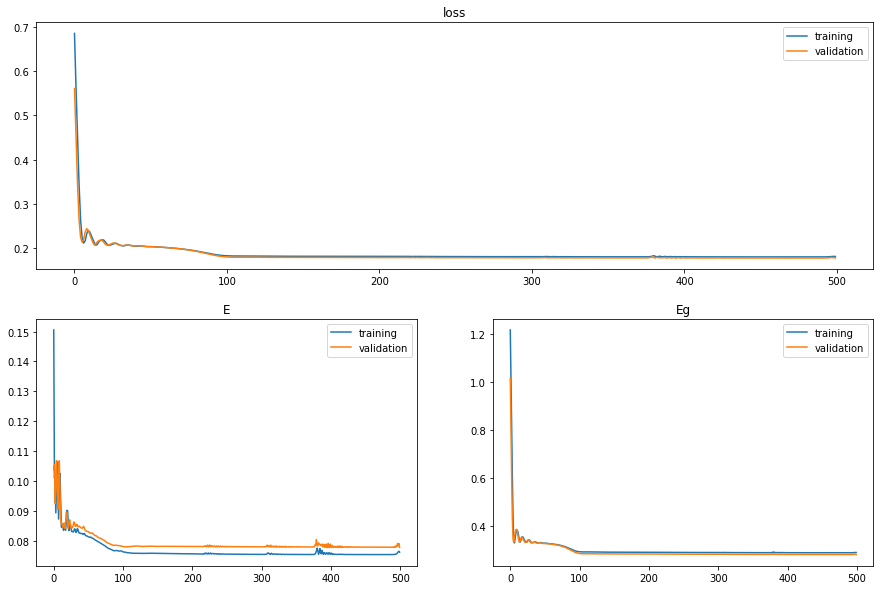

In [260]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.title('loss')
plt.plot(loss_data[:, 0], loss_data[:, 1], label='training')
plt.plot(loss_data[:, 0], loss_data[:, 4], label='validation')
plt.legend()

plt.subplot(2, 2, 3)
plt.title(t1)
plt.plot(loss_data[:, 0], loss_data[:, 2], label='training')
plt.plot(loss_data[:, 0], loss_data[:, 5], label='validation')
plt.legend()

plt.subplot(2, 2, 4)
plt.title(t2)
plt.plot(loss_data[:, 0], loss_data[:, 3], label='training')
plt.plot(loss_data[:, 0], loss_data[:, 6], label='validation')
plt.legend()

plt.show()

## Validation

In [261]:
loss, pred_y = sess.run([loss_total, output], {tf_x: X_validation, tf_y: y_validation, tf_is_training: False})

print('loss:', loss)

loss: 0.17843962


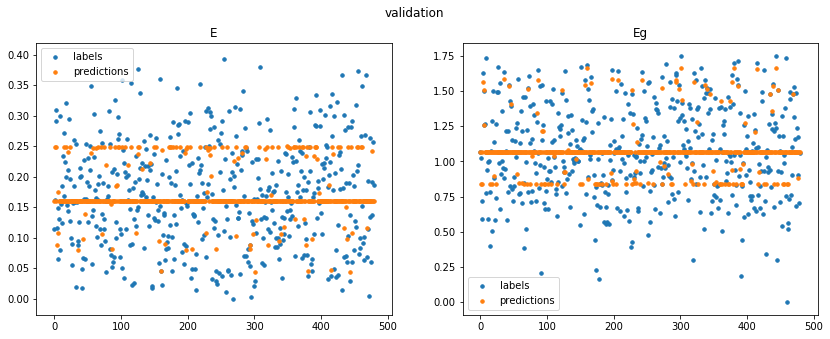

In [262]:
n_row = len(y_validation)

plt.figure(figsize=(14, 5))
plt.suptitle('validation')

# Formation energy
plt.subplot(1, 2, 1)
plt.title(t1)
plt.scatter(range(n_row), y_validation[t1], s=12, label='labels')
plt.scatter(range(n_row), pred_y[:, 0], s=12, label='predictions')
plt.legend()

# Bandgap energy
plt.subplot(1, 2, 2)
plt.title(t2)
plt.scatter(range(n_row), y_validation[t2], s=12, label='labels')
plt.scatter(range(n_row), pred_y[:, 1], s=12, label='predictions')
plt.legend()

plt.show()

In [263]:
loss, pred_y = sess.run([loss_total, output], {tf_x: X_validation, tf_y: y_validation, tf_is_training: False})

print('loss:', loss)

loss: 0.17843962


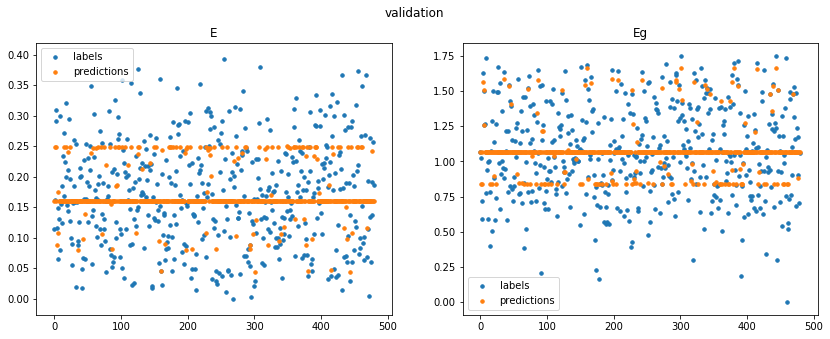

In [264]:
n_row = len(y_validation)

plt.figure(figsize=(14, 5))
plt.suptitle('validation')

# Formation energy
plt.subplot(1, 2, 1)
plt.title(t1)
plt.scatter(range(n_row), y_validation[t1], s=12, label='labels')
plt.scatter(range(n_row), pred_y[:, 0], s=12, label='predictions')
plt.legend()

# Bandgap energy
plt.subplot(1, 2, 2)
plt.title(t2)
plt.scatter(range(n_row), y_validation[t2], s=12, label='labels')
plt.scatter(range(n_row), pred_y[:, 1], s=12, label='predictions')
plt.legend()